# City of Los Angeles CA. Data on crime reports since 2010
### Dataset for this Notebook:
[LA CRIME SOURCE DATA](https://catalog.data.gov/dataset/crime-data-from-2010-to-present)


In [41]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import time
import matplotlib.pyplot as plt

import diffs_latlong
from diffs_latlong import computeNearestZip

csv_file = "Resources/Crime_Data_from_2010_to_Present.csv"


In [42]:
# Load data from csv file
crime_df = pd.read_csv(csv_file)

In [43]:
crime_df.tail(2)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Weapon Description,Status Code,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,Location
1972132,191005089,01/26/2019,01/01/2010,1000,10,West Valley,1029,354,THEFT OF IDENTITY,1822 0377,...,NaN,IC,Invest Cont,354.0,NaN,NaN,NaN,7000 WOODLEY AV,NaN,"(34.1976, -118.4837)"
1972133,191505220,01/24/2019,01/05/2010,700,15,N Hollywood,1555,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",1202 0701,...,NaN,IC,Invest Cont,341.0,NaN,NaN,NaN,5000 LANKERSHIM BL,NaN,"(34.1611, -118.3723)"


In [44]:
# The 'Location ' column has a blank space at the end
crime_df.columns

Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location '],
      dtype='object')

In [45]:
crime_df = crime_df.rename(columns={"Location ": "location"})

In [46]:
# Inspect the new location column
crime_df.columns[-1]

'location'

In [47]:
crime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972134 entries, 0 to 1972133
Data columns (total 26 columns):
DR Number                 int64
Date Reported             object
Date Occurred             object
Time Occurred             int64
Area ID                   int64
Area Name                 object
Reporting District        int64
Crime Code                int64
Crime Code Description    object
MO Codes                  object
Victim Age                int64
Victim Sex                object
Victim Descent            object
Premise Code              float64
Premise Description       object
Weapon Used Code          float64
Weapon Description        object
Status Code               object
Status Description        object
Crime Code 1              float64
Crime Code 2              float64
Crime Code 3              float64
Crime Code 4              float64
Address                   object
Cross Street              object
location                  object
dtypes: float64(6), int64(6),

In [48]:
# Regex to extract lat and long out of the location column
# and make 2 new columns from the values.
crime_df[['lat', 'long']] = crime_df['location'].replace\
    (to_replace=["\)","\("], value="", regex=True).str.split(",", expand = True)

In [49]:
# Inspect the new columns
crime_df.iloc[-3:,-5:]

,Address,Cross Street,location,lat,long
1972131,69TH ST,DENKER AV,"(33.977, -118.3046)",33.977,-118.3046
1972132,7000 WOODLEY AV,NaN,"(34.1976, -118.4837)",34.1976,-118.4837
1972133,5000 LANKERSHIM BL,NaN,"(34.1611, -118.3723)",34.1611,-118.3723


In [50]:
# Convert lat and longs to numeric values: 
# Needed for the computeNearestZip function(Extract zip from lat long)
crime_df['lat'] = pd.to_numeric(crime_df['lat'])
crime_df['long'] = pd.to_numeric(crime_df['long'])

In [51]:
type(crime_df['lat'][0]), type(crime_df['long'][0])

(numpy.float64, numpy.float64)

### Examining the structure of the dataframe

In [52]:
len(crime_df.columns)

28

In [53]:
crime_df.shape

(1972134, 28)

In [54]:
# 15 columns that have no missing values at all
crime_df.dropna(axis=1).shape

(1972134, 15)

In [55]:
# only 19 rows out of 1967976 are without missing values
crime_df.dropna(axis=0).shape

(19, 28)

In [56]:
print(f"Total rows in age column: {crime_df['Victim Age'].count()}")
print(f"Total rows with age == 0: {crime_df[crime_df['Victim Age']==0]['Victim Age'].count()}")
print("Rows with age == 0:",\
     round(float(crime_df[crime_df['Victim Age']==0]['Victim Age']\
                  .count()/crime_df['Victim Age'].count()*100),2), '%')



Total rows in age column: 1972134
Total rows with age == 0: 362180
Rows with age == 0: 18.36 %


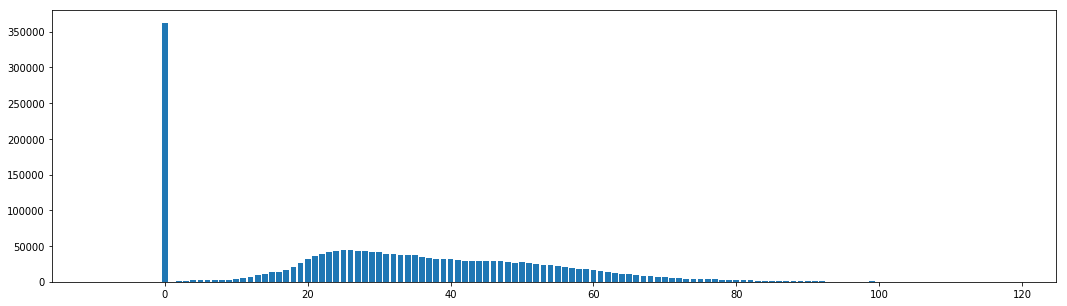

In [57]:
# Quick visual inspection of the 'Victim Age' column for the above reasons ☝🏾
data = crime_df['Victim Age'].value_counts()
names = list(data.index)
fig, axs = plt.subplots(figsize=(18, 5))
axs.bar(names, data)

plt.show()

In [58]:
# Ages with negative numbers exactly 9 😰
# it probalby refers to an unborn victim (pregnancy stage of victim's mother)?
crime_df[crime_df['Victim Age'] < 0].groupby('Victim Age')['Victim Age'].count()


Victim Age
-9      2
-8      1
-7      4
-6     10
-5     17
-4     23
-3     51
-2    102
-1    221
Name: Victim Age, dtype: int64

In [59]:
# About the huge amount of zeros in dataset:
# coud be that in data entry process the person preparing the report
# could not leave the field blank for unknown ages?:
#No missing values in this column
crime_df['Victim Age'].isnull().values.any(), crime_df['Victim Age'].isnull().values.sum()


(False, 0)

In [60]:
print(f"Total columns in dataset: {len(crime_df.columns)}")
print(f"Number of Columns with no missing values: {len(crime_df.dropna(axis=1).columns)}")

Total columns in dataset: 28
Number of Columns with no missing values: 15


In [61]:
print(f" Only {len(crime_df.dropna(axis=0))}\
 Rows with no missing values out of {len(crime_df)} total Rows")


 Only 19 Rows with no missing values out of 1972134 total Rows


# Mapping lat long to a zip code with helper funcion imported from diffs_latlong.py

In [62]:
# Wrapper function needed to execute the computeNearestZip script.
def zipWrapper(myDf):
    lat = myDf['lat']
    long = myDf['long']
    return computeNearestZip(lat, long)


In [71]:
# Create a slice of the original dataframe to use in the project
_100k_crime_df = crime_df[:100000].copy()
_100k_crime_df.tail(2)


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Status Description,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,location,lat,long
99998,140504326,01/09/2014,01/07/2014,900,5,Harbor,581,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0352,...,Invest Cont,341.0,NaN,NaN,NaN,2100 MCRAE DR,NaN,"(33.7263, -118.3208)",33.7263,-118.3208
99999,140504327,01/09/2014,01/09/2014,1,5,Harbor,563,624,BATTERY - SIMPLE ASSAULT,0416 0429 0444,...,Invest Cont,624.0,NaN,NaN,NaN,13TH,GAFFEY,"(33.7324, -118.2924)",33.7324,-118.2924


In [72]:
# Function to test the time it takes for our computeNearestzip function to run
def df_maker():
    begining = time.time()
    _100k_crime_df['zip'] = _100k_crime_df.apply(func=zipWrapper, axis=1)
    end = time.time()
    total = end-begining
    print(f"It took {total} seconds to process {len(_100k_crime_df['zip'])} Rows")
    return _100k_crime_df
          

In [74]:
df_maker()

It took 6132.920296907425 seconds to process 100000 Rows


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,location,lat,long,zip
0,11401303,09/13/2010,09/12/2010,45,14,Pacific,1485,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,...,740.0,NaN,NaN,NaN,SEPULVEDA BL,MANCHESTER AV,"(33.9599, -118.3962)",33.9599,-118.3962,90045
1,70309629,08/09/2010,08/09/2010,1515,13,Newton,1324,946,OTHER MISCELLANEOUS CRIME,0344,...,946.0,NaN,NaN,NaN,1300 E 21ST ST,NaN,"(34.0224, -118.2524)",34.0224,-118.2524,90021
2,100100508,01/08/2010,01/07/2010,2005,1,Central,182,330,BURGLARY FROM VEHICLE,0344,...,330.0,NaN,NaN,NaN,PICO BL,GRAND AV,"(34.0389, -118.2643)",34.0389,-118.2643,90015
3,100100511,01/09/2010,01/06/2010,2100,1,Central,132,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344 1402,...,341.0,998.0,NaN,NaN,200 S OLIVE ST,NaN,"(34.0538, -118.2488)",34.0538,-118.2488,90071
4,100100523,01/15/2010,01/15/2010,245,1,Central,182,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,...,740.0,NaN,NaN,NaN,1100 S OLIVE ST,NaN,"(34.0409, -118.2609)",34.0409,-118.2609,90015
5,100100552,01/23/2010,01/23/2010,1225,1,Central,192,237,CHILD NEGLECT (SEE 300 W.I.C.),1251,...,237.0,NaN,NaN,NaN,1300 S FLOWER ST,NaN,"(34.0401, -118.2668)",34.0401,-118.2668,90015
6,100100562,01/28/2010,01/28/2010,2345,1,Central,152,626,INTIMATE PARTNER - SIMPLE ASSAULT,0416 2000,...,626.0,NaN,NaN,NaN,500 S GRAND AV,NaN,"(34.0502, -118.254)",34.0502,-118.2540,90071
7,100100575,02/01/2010,01/31/2010,1720,1,Central,181,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",1402,...,341.0,NaN,NaN,NaN,1100 S FIGUEROA ST,NaN,"(34.0437, -118.2652)",34.0437,-118.2652,90015
8,100100610,02/11/2010,02/10/2010,1800,1,Central,162,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),0325 1402,...,442.0,998.0,NaN,NaN,700 W 7TH ST,NaN,"(34.048, -118.2577)",34.0480,-118.2577,90071
9,100100616,02/11/2010,02/11/2010,1515,1,Central,192,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",1212,...,341.0,NaN,NaN,NaN,PICO,GRAND,"(34.0389, -118.2643)",34.0389,-118.2643,90015


In [77]:
_100k_crime_df.tail()


,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,location,lat,long,zip
99995,140504322,01/08/2014,01/07/2014,2000,5,Harbor,509,440,THEFT PLAIN - PETTY ($950 & UNDER),0344,...,440.0,NaN,NaN,NaN,1400 W LOMITA BL,NaN,"(33.7978, -118.3011)",33.7978,-118.3011,90710
99996,140504323,01/08/2014,01/08/2014,2315,5,Harbor,567,626,INTIMATE PARTNER - SIMPLE ASSAULT,2000 1813 0444 0913 0416,...,626.0,NaN,NaN,NaN,1500 S PALOS VERDES ST,NaN,"(33.7306, -118.2814)",33.7306,-118.2814,90731
99997,140504325,01/08/2014,01/08/2014,1500,5,Harbor,558,310,BURGLARY,0344 0358 1606 1402,...,310.0,998.0,NaN,NaN,200 W SEPULVEDA ST,NaN,"(33.7451, -118.2817)",33.7451,-118.2817,90731
99998,140504326,01/09/2014,01/07/2014,900,5,Harbor,581,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0352,...,341.0,NaN,NaN,NaN,2100 MCRAE DR,NaN,"(33.7263, -118.3208)",33.7263,-118.3208,90732
99999,140504327,01/09/2014,01/09/2014,1,5,Harbor,563,624,BATTERY - SIMPLE ASSAULT,0416 0429 0444,...,624.0,NaN,NaN,NaN,13TH,GAFFEY,"(33.7324, -118.2924)",33.7324,-118.2924,90731


In [78]:
_100k_crime_df['date reported formatted'] = pd.to_datetime(_100k_crime_df['Date Reported'], infer_datetime_format=True)

In [88]:
_100k_crime_df[['date reported formatted']].sort_values(by='date reported formatted', ascending=False).head()

,date reported formatted
64142,2019-04-26
64067,2019-04-23
64145,2019-04-22
64151,2019-04-22
64066,2019-04-22


In [96]:
cols = list(_100k_crime_df.columns)

In [97]:
cols = cols[-1:] + cols[:-1]

In [99]:
cols.insert(0, 'DR Number')

In [101]:
cols.pop(2)

'DR Number'

In [102]:
cols

['DR Number',
 'date reported formatted',
 'Date Reported',
 'Date Occurred',
 'Time Occurred',
 'Area ID',
 'Area Name',
 'Reporting District',
 'Crime Code',
 'Crime Code Description',
 'MO Codes',
 'Victim Age',
 'Victim Sex',
 'Victim Descent',
 'Premise Code',
 'Premise Description',
 'Weapon Used Code',
 'Weapon Description',
 'Status Code',
 'Status Description',
 'Crime Code 1',
 'Crime Code 2',
 'Crime Code 3',
 'Crime Code 4',
 'Address',
 'Cross Street',
 'location',
 'lat',
 'long',
 'zip']

In [103]:
_100k_crime_df = _100k_crime_df[cols].copy()

In [105]:
_100k_crime_df.tail(2)

,DR Number,date reported formatted,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,...,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,location,lat,long,zip
99998,140504326,2014-01-09,01/09/2014,01/07/2014,900,5,Harbor,581,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,341.0,NaN,NaN,NaN,2100 MCRAE DR,NaN,"(33.7263, -118.3208)",33.7263,-118.3208,90732
99999,140504327,2014-01-09,01/09/2014,01/09/2014,1,5,Harbor,563,624,BATTERY - SIMPLE ASSAULT,...,624.0,NaN,NaN,NaN,13TH,GAFFEY,"(33.7324, -118.2924)",33.7324,-118.2924,90731


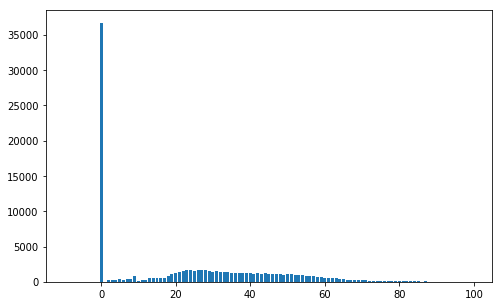

In [151]:
# Quick visual inspection of the 'Victim Age' 100k rows
data = _100k_crime_df['Victim Age'].value_counts()
names = list(data.index)
fig, axs = plt.subplots(figsize=(8,5))
axs.bar(names, data)

plt.show()

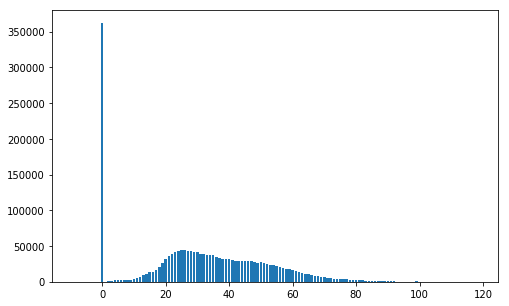

In [152]:
# Quick visual inspection of the 'Victim Age' 1.9 mill rows
data = crime_df['Victim Age'].value_counts()
names = list(data.index)
fig, axs = plt.subplots(figsize=(8,5))
axs.bar(names, data)

plt.show()

# Load  (Mongo and SQL)

In [106]:
# Save the _1k_crime_df to a csv file
#added the amount of rows to the name of the file for easy finding
_100k_crime_df.to_csv(f"Resources/crime{_100k_crime_df['zip'].count()}.csv", index=False)


# mongodb

In [107]:
import pymongo

In [108]:
# Setup connection to mongodb
conn = "mongodb://localhost:27017"
client = pymongo.MongoClient(conn)

# Select database and collection to use
db = client.la_crime_100k
crime_reports = db.crime_reports

In [109]:
# Convert the dataframe to dictionary format for mongo
crimeData = _100k_crime_df.to_dict(orient='records')

In [110]:
# inspect the dictionary 
crimeData[0]

{'DR Number': 11401303,
 'date reported formatted': Timestamp('2010-09-13 00:00:00'),
 'Date Reported': '09/13/2010',
 'Date Occurred': '09/12/2010',
 'Time Occurred': 45,
 'Area ID': 14,
 'Area Name': 'Pacific',
 'Reporting District': 1485,
 'Crime Code': 740,
 'Crime Code Description': 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)',
 'MO Codes': '0329',
 'Victim Age': 0,
 'Victim Sex': 'M',
 'Victim Descent': 'W',
 'Premise Code': 101.0,
 'Premise Description': 'STREET',
 'Weapon Used Code': nan,
 'Weapon Description': nan,
 'Status Code': 'IC',
 'Status Description': 'Invest Cont',
 'Crime Code 1': 740.0,
 'Crime Code 2': nan,
 'Crime Code 3': nan,
 'Crime Code 4': nan,
 'Address': 'SEPULVEDA                    BL',
 'Cross Street': 'MANCHESTER                   AV',
 'location': '(33.9599, -118.3962)',
 'lat': 33.9599,
 'long': -118.3962,
 'zip': '90045'}

### First Collection: LA Crime Data

In [111]:
crime_reports.insert_many(crimeData)

In [128]:
# Test query the mongo db
results = crime_reports.find()
for result in results[:2]:
    print(result, '\n')

{'_id': ObjectId('5ce41f22be1a77b335fc0108'), 'DR Number': 11401303, 'Date Reported': '09/13/2010', 'Date Occurred': '09/12/2010', 'Time Occurred': 45, 'Area ID': 14, 'Area Name': 'Pacific', 'Reporting District': 1485, 'Crime Code': 740, 'Crime Code Description': 'VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)', 'MO Codes': '0329', 'Victim Age': 0, 'Victim Sex': 'M', 'Victim Descent': 'W', 'Premise Code': 101.0, 'Premise Description': 'STREET', 'Weapon Used Code': nan, 'Weapon Description': nan, 'Status Code': 'IC', 'Status Description': 'Invest Cont', 'Crime Code 1': 740.0, 'Crime Code 2': nan, 'Crime Code 3': nan, 'Crime Code 4': nan, 'Address': 'SEPULVEDA                    BL', 'Cross Street': 'MANCHESTER                   AV', 'location': '(33.9599, -118.3962)', 'lat': 33.9599, 'long': -118.3962, 'zip': '90045'} 

{'_id': ObjectId('5ce41f22be1a77b335fc0109'), 'DR Number': 70309629, 'Date Reported': '08/09/2010', 'Date Occurred': '08/09/2010', 'Time Occurred': 1515, 'Area 

## Second Collection: Census zips:

In [112]:
# Read in from census zips csv file
census_df = pd.read_csv('Resources/censusZips2017.csv')
census_df[:2]

,Zipcode,Population,Unemployment Count,Unemployment Rate
0,601,17599.0,2454.0,13.943974
1,602,39209.0,2538.0,6.473004


In [113]:
# Save df to dictionary for mongo uploading
censusData = census_df.to_dict(orient = 'records')

In [114]:
### Create the  collection to hold census data
censusZips = db.censusZips

In [115]:
censusZips.insert_many(censusData)

In [116]:
## Test query the mongodb new collection
censusResults = censusZips.find()

In [117]:
for result in censusResults[:2]:
    print(result, '\n')

{'_id': ObjectId('5ce69699a3a7e51e423ded51'), 'Zipcode': 601, 'Population': 17599.0, 'Unemployment Count': 2454.0, 'Unemployment Rate': 13.943974089436901} 

{'_id': ObjectId('5ce69699a3a7e51e423ded52'), 'Zipcode': 602, 'Population': 39209.0, 'Unemployment Count': 2538.0, 'Unemployment Rate': 6.473003647121835} 



#  SQL

In [120]:
from sqlalchemy import create_engine

In [127]:
database_path = "Resources/la_crime_100k.sqlite"

In [128]:
engine = create_engine(f"sqlite:///{database_path}")

In [129]:
engine.table_names()

[]

### First Table: LA crime data

In [131]:
_100k_crime_df.to_sql(name='LaCrime', con=engine, if_exists='append', index=False)


In [132]:
engine.table_names()

['LaCrime']

In [133]:
# Test Query the LaCrime table
pd.read_sql_query('select * from LaCrime', con=engine).tail(2)


,DR Number,date reported formatted,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,...,Crime Code 1,Crime Code 2,Crime Code 3,Crime Code 4,Address,Cross Street,location,lat,long,zip
99998,140504326,2014-01-09 00:00:00.000000,01/09/2014,01/07/2014,900,5,Harbor,581,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",...,341.0,NaN,NaN,NaN,2100 MCRAE DR,None,"(33.7263, -118.3208)",33.7263,-118.3208,90732
99999,140504327,2014-01-09 00:00:00.000000,01/09/2014,01/09/2014,1,5,Harbor,563,624,BATTERY - SIMPLE ASSAULT,...,624.0,NaN,NaN,NaN,13TH,GAFFEY,"(33.7324, -118.2924)",33.7324,-118.2924,90731


## Second Table: Census zips:

In [134]:
# Import data for the census table
censusData = pd.read_csv('Resources/censusZips2017.csv')


In [135]:
censusData[:2]


,Zipcode,Population,Unemployment Count,Unemployment Rate
0,601,17599.0,2454.0,13.943974
1,602,39209.0,2538.0,6.473004


In [136]:
# check tables
engine.table_names()


['LaCrime']

In [137]:
# Create the new CensusZips table 
censusData.to_sql(name='CensusZips', con=engine, if_exists='append', index=False)


In [138]:
engine.table_names()


['CensusZips', 'LaCrime']

### Test Query the CensusZips table

In [139]:
pd.read_sql_query('select * from CensusZips', con=engine).tail()


,Zipcode,Population,Unemployment Count,Unemployment Rate
33115,99923,0.0,0.0,NaN
33116,99925,901.0,124.0,13.762486
33117,99926,1684.0,132.0,7.838480
33118,99927,59.0,0.0,0.000000
33119,99929,2455.0,83.0,3.380855


# Test Query both tables  performing a join on the zip code

In [140]:
query1 = '''
SELECT
    LaCrime.zip, COUNT(LaCrime.zip) AS crime_reports_count, `Unemployment Rate` AS `zip_unemployment_%`
FROM
    LaCrime JOIN CensusZips ON LaCrime.zip = CensusZips.Zipcode
GROUP BY
    LaCrime.zip ORDER by count(LaCrime.zip) DESC
'''

query2 = '''
SELECT
    LaCrime.zip, COUNT(LaCrime.zip) AS crime_reports_count, `Unemployment Rate` AS `zip_unemployment_%`
FROM
    LaCrime JOIN CensusZips ON LaCrime.zip = CensusZips.Zipcode
GROUP BY
    LaCrime.zip ORDER BY `Unemployment Rate`DESC
'''

In [141]:
pd.read_sql_query(query1, con=engine)


,zip,crime_reports_count,zip_unemployment_%
0,90057,4361,4.946446
1,90008,3575,5.537872
2,90007,3265,5.885350
3,90033,3101,3.097807
4,90018,3059,5.163807
5,90013,3041,6.832818
6,90037,2852,4.558968
7,90062,2742,4.130609
8,90016,2717,4.178995
9,90017,2624,3.486169


In [142]:
pd.read_sql_query(query2, con=engine)


,zip,crime_reports_count,zip_unemployment_%
0,90028,1633,7.834739
1,90302,22,7.772239
2,91602,388,6.888725
3,90013,3041,6.832818
4,90068,105,6.558962
5,90043,735,6.531153
6,90021,762,6.396453
7,90047,573,6.042358
8,91403,426,6.009645
9,90007,3265,5.885350


## Row 149 zip code 90012

[90012 stats @ unitedstateszipcodes.org](https://www.unitedstateszipcodes.org/90012/)

-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------

## TESTING LINES 👇🏾

#### FALIED TEST TO THE ZIP EXTRACTION FUNCTION @ BOTTOM

In [ ]:
# 😾
small_df = crime_df[:10]
small_df

small_df['zip'] = small_df.apply(computeNearestZip(small_df['lat'],small_df['long']), axis=1)
